# A couple of things from HW08
## Adding metadata
I saw a lot of folks using a dictionary strategy combined with a `merge` to add metadata:
```python
d_1 = {'FILENAME':'00020324.txt','Main_Character':'Black'}
d_2 = {'FILENAME':'00020055.txt','Main_Character':'Black'}
d_3 = {'FILENAME':'00020084.txt','Main_Character':'Black'}
d_4 = {'FILENAME':'00020213.txt','Main_Character':'Black'}
d_5 = {'FILENAME':'00020738.txt','Main_Character':'Black'}
...
```
This works! But it's a lot of work. I wanted to show one other way that might save you time.

We can add new columns to an existing dataframe using simple `[]` notation, which maintains the relationship in the order given by the rows in the dataframe. To go back to the old coffee shop example:

In [91]:
import pandas as pd

coffee = {'food':'coffee','size':'8oz','price':'$3.00'}
banana ={'food':'banana','size':'4oz','price':'$0.50'}
donut = {'food':'donut', 'size':'6oz', 'price':'$1.00'}
food_df = pd.DataFrame([coffee,banana,donut])

In [92]:
food_df

,food,price,size
0,coffee,$3.00,8oz
1,banana,$0.50,4oz
2,donut,$1.00,6oz


We can add a new column like so:

In [93]:
food_df['sales'] = [100, 3, 23]

Now the dataframe includes the data in that list under the new columns `sales`:

In [94]:
food_df

,food,price,size,sales
0,coffee,$3.00,8oz,100
1,banana,$0.50,4oz,3
2,donut,$1.00,6oz,23


We can also overwrite that data *in place*, e.g. if our `sales` go up:

In [95]:
food_df['sales'] = [2384004, 83210, 955]

In [96]:
food_df

,food,price,size,sales
0,coffee,$3.00,8oz,2384004
1,banana,$0.50,4oz,83210
2,donut,$1.00,6oz,955


In [98]:
food_df['sales'] > 1000

0     True
1     True
2    False
Name: sales, dtype: bool

## Gone `fish`ing
Many folks were having troubles with `0` and `inf` values in the Fisher's exact function. Generally these occur when one word only appears in one of the groups. I updated it to fix that problem. Now the function returns a dataframe pre-filtered to ignore `0` and `inf` odds, as well as only return results with p-values `< 0.05`.

In [35]:
from scipy.stats import fisher_exact
import pandas as pd
import numpy as np


def fish(group_a, group_a_name, group_b, group_b_name):
    results = []
    
    if (group_a.columns == group_b.columns).all(): 
        for word in group_a.columns:
           
            sum_word_a = group_a[word].sum()
            sum_word_b = group_b[word].sum()

            sum_allword_a = group_a.sum().sum()
            sum_allword_b = group_b.sum().sum()

            sum_notword_a = sum_allword_a - sum_word_a
            sum_notword_b = sum_allword_b - sum_word_b

            contingency_table = [[sum_word_a, sum_notword_a], [sum_word_b, sum_notword_b]]

            odds,pvalue = fisher_exact(contingency_table)

            d = {}
            d['word'] = word
            d['odds'] = odds
            d['pvalue'] = pvalue
            d['group_a']= group_a_name
            d['group_b'] = group_b_name

            results.append(d)
    
    # NEW
    df = pd.DataFrame(results)
    df = df[(df['pvalue'] < 0.05) & (df['odds'] != np.inf) & (df['odds'] > 0)]
    
    return df.sort_values('odds')

Demoing the new function. Remember that `make_dtm` has been updated with the `keep_top` argument:

In [2]:
from make_dtm import *

In [3]:
sotus = '/Users/e/code/literarytextmining/corpora/sotu_1900-2019/texts'

In [4]:
import pandas as pd
meta = '/Users/e/code/literarytextmining/corpora/sotu_1900-2019/meta.csv'
meta = pd.read_csv(meta)

In [36]:
dtm = make_dtm(sotus, scaled = False, keep_top = 200) # choosing to keep very high frequency words only

In [37]:
dtm.head()

,a,about,act,action,administration,against,all,also,am,america,...,who,will,with,without,work,world,would,year,years,you
filepath,,,,,,,,,,,,,,,,,,,,,
1900.McKinley.txt,253,11.0,19.0,24.0,14.0,21.0,72,9.0,9.0,1.0,...,10,84,140,13.0,23.0,10.0,13.0,48.0,8.0,11.0
1901.Roosevelt.txt,275,4.0,16.0,12.0,12.0,25.0,83,23.0,1.0,2.0,...,77,83,140,13.0,40.0,30.0,47.0,9.0,26.0,2.0
1902.Roosevelt.txt,181,5.0,6.0,9.0,2.0,11.0,33,11.0,1.0,3.0,...,16,34,73,8.0,21.0,13.0,36.0,7.0,5.0,1.0
1903.Roosevelt.txt,215,8.0,13.0,10.0,4.0,15.0,42,2.0,1.0,3.0,...,22,54,98,9.0,22.0,16.0,26.0,39.0,19.0,2.0
1904.Roosevelt.txt,247,7.0,15.0,11.0,8.0,24.0,81,15.0,5.0,2.0,...,49,53,111,11.0,50.0,11.0,43.0,12.0,13.0,4.0


In [38]:
meta.columns

Index(['president', 'year', 'filepath', 'party'], dtype='object')

In [39]:
df = pd.merge(dtm, meta[['filepath', 'party']], on = 'filepath')

In [40]:
words = df.set_index('filepath').columns[:-1]

In [41]:
words[:5], words[-5:]

(Index(['a', 'about', 'act', 'action', 'administration'], dtype='object'),
 Index(['world', 'would', 'year', 'years', 'you'], dtype='object'))

In [43]:
Rs = df[df['party'] == 'Republican'][words]
Ds = df[df['party'] == 'Democrat'][words]

In [44]:
len(Rs), len(Ds)

(63, 56)

New Fisher's test with built-in preprocessing:

In [45]:
fish(Rs, 'Repubs', Ds, 'Dems')
# this takes about 1 minute to run on my computer

,group_a,group_b,odds,pvalue,word
151,Repubs,Dems,0.186100,2.605968e-73,t
99,Repubs,Dems,0.263936,2.981662e-53,million
83,Repubs,Dems,0.283791,5.162219e-43,jobs
85,Repubs,Dems,0.379841,2.342799e-33,know
137,Repubs,Dems,0.444249,1.626723e-97,s
65,Repubs,Dems,0.468433,7.492037e-21,health
199,Repubs,Dems,0.471052,1.163986e-51,you
149,Repubs,Dems,0.473417,3.618078e-18,support
133,Repubs,Dems,0.480822,2.121516e-23,program
167,Repubs,Dems,0.490062,3.471089e-16,today


# `nltk` behaving badly
`nltk`'s part of speech tagging and named entity recognition have an expected error rate, but some people saw significantly more errors than usual. Part of the reason for that comes from text pre-processing like `lower()`. `nltk` uses some features of texts that we normalize for the purpose of making a DTM to evaluate aspects of texts. Just as an example, take the results from this sentence from a New York Times headline from this morning:

In [46]:
import nltk

In [53]:
nyt = 'For the last five weeks, more than 200,000 Iraqis across the country have gathered on any given day to demonstrate against the government. Security forces have killed at least 320 and wounded about 15,000, according to the United Nations office in Iraq.'

In [54]:
nyt

'For the last five weeks, more than 200,000 Iraqis across the country have gathered on any given day to demonstrate against the government. Security forces have killed at least 320 and wounded about 15,000, according to the United Nations office in Iraq.'

In [55]:
# this loop checks to see if the tags are equivalent
for x,y in zip(nltk.pos_tag(nyt.split(' ')), nltk.pos_tag(nyt.lower().split(' '))):
    if x == y:
        continue
    else: # in cases where they are different, print the different values
        print(x, y)

('For', 'IN') ('for', 'IN')
('Iraqis', 'NNP') ('iraqis', 'JJ')
('Security', 'NNP') ('security', 'NN')
('United', 'NNP') ('united', 'JJ')
('Nations', 'NNP') ('nations', 'NNS')
('Iraq.', 'NNP') ('iraq.', 'NN')


For those of you who were seeing errors with words like `i` and `mr`, this is one reason why. Named entity recognition relies on some of the same tricks, which will also output similar results.

# Plotting word frequencies

In [99]:
corp_path = '/Users/e/Library/Mobile Documents/com~apple~CloudDocs/PhD/ltm/corpora/race/texts'

In [100]:
# new version takes about 1 second per novel to process on my computer
dtm = make_dtm(corp_path, scaled = True, keep_top = 4000)

In [101]:
meta_path = '/Users/e/Library/Mobile Documents/com~apple~CloudDocs/PhD/ltm/corpora/race/meta.csv'
meta = pd.read_csv(meta_path)

In [102]:
df = pd.merge(dtm, meta[['FILENAME','PUBL_DATE', 'LIBRARIES', 'TITLE']], left_on='filepath', right_on='FILENAME')

In [103]:
df.head()

,a,aaron,abandoned,able,about,above,abruptly,absence,absolutely,absurd,...,yourself,youth,youve,yul,zelenko,zulfiqar,FILENAME,PUBL_DATE,LIBRARIES,TITLE
0,0.025098,NaN,0.000011,0.000068,0.002253,0.000649,0.000028,0.000006,0.000045,0.000040,...,0.000203,0.000079,0.000231,NaN,NaN,NaN,00020055.txt,1952,1577,Invisible Man
1,0.014889,NaN,NaN,0.000113,0.001088,0.000300,NaN,NaN,0.000038,NaN,...,0.000188,NaN,0.000038,NaN,NaN,NaN,00020063.txt,1952,2499,The old man and the sea
2,0.016666,NaN,0.000037,0.000311,0.001628,0.000485,0.000112,NaN,NaN,NaN,...,0.000099,0.000025,NaN,NaN,NaN,NaN,00020084.txt,1953,953,Go tell it on the mountain
3,0.022344,0.000008,0.000020,0.000192,0.003251,0.000132,0.000004,0.000004,0.000084,0.000008,...,0.000253,0.000012,0.000164,NaN,NaN,NaN,00020085.txt,1953,2080,The adventures of Augie March
4,0.028819,0.000451,0.000020,0.000108,0.003373,0.000088,0.000028,0.000016,0.000196,0.000036,...,0.000299,0.000028,0.000651,NaN,0.000255,NaN,00020209.txt,1955,2398,Marjorie Morningstar


We talked about using line plots to show the relationship between word frequencies over time:

In [104]:
df.sort_values('PUBL_DATE', inplace=True) # to prevent the plotting function from moving out of order

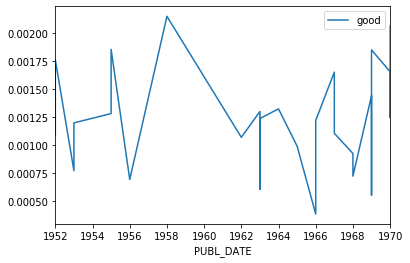

In [107]:
df.plot(x = 'PUBL_DATE', y = 'good')

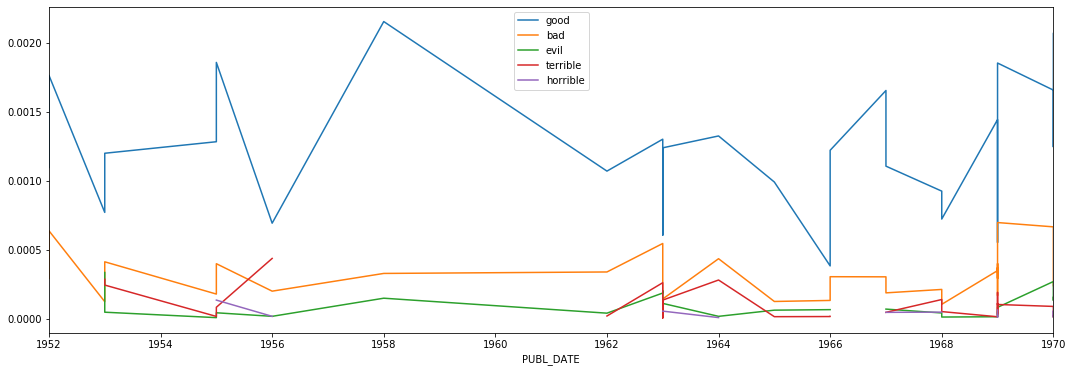

In [106]:
df.plot(x = 'PUBL_DATE', y = ['good','bad', 'evil', 'terrible', 'horrible'], figsize = (18,6))

# Combined word frequencies over time
Of course, another way to handle these word frequencies would be not to represent them individually, but collectively as with the "hard seed" words referenced in Heuser and Le-Khac, as well as Underwood. Since they are already scaled, we can accomplish this by summing their vectors, assuming we wish to weight the books equally:

In [66]:
colors = ['red','orange','yellow','green','blue','white','black']
df[colors].sum(axis = 'columns')

0     0.004940
1     0.002138
2     0.002523
3     0.002285
29    0.001488
4     0.003433
5     0.001512
6     0.002421
7     0.001398
8     0.003258
9     0.001691
10    0.001366
11    0.001233
12    0.006806
14    0.006614
13    0.002996
15    0.004244
16    0.003527
18    0.002627
17    0.004019
19    0.003507
20    0.001936
21    0.002764
22    0.001264
23    0.001351
24    0.002736
25    0.003113
26    0.006740
27    0.004735
28    0.001771
dtype: float64

We can add this reuslt as a new column in our dataframe, and then easily plot it:

In [108]:
df['colors_combined'] = df[colors].sum(axis = 'columns')

In [109]:
df.sort_values('PUBL_DATE', inplace = True) # this ensures that the data on the x-axis is plotted in temporal order

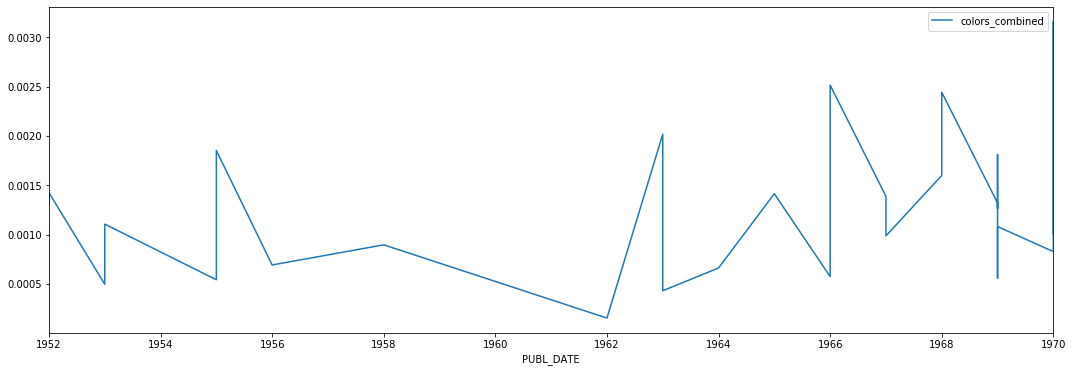

In [110]:
df.plot(x = 'PUBL_DATE', y = 'colors_combined', figsize = (18,6))

How about those same results without `white` and `black`?

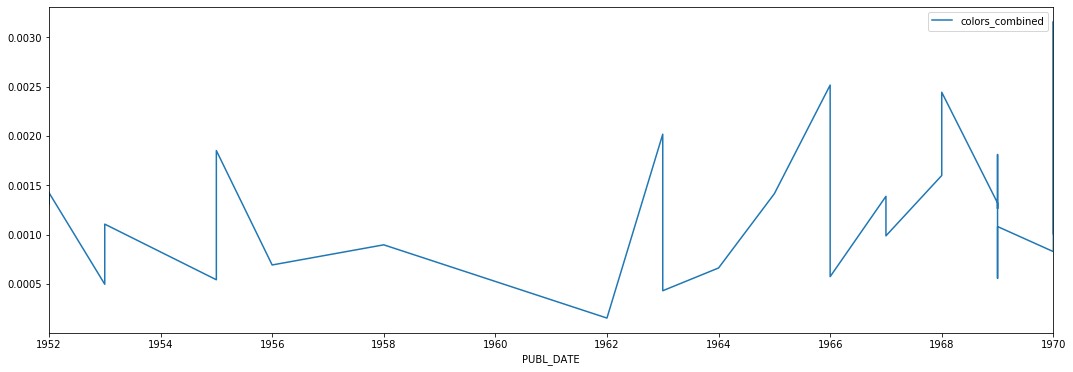

In [111]:
colors = ['red','orange','yellow','green','blue']
df['colors_combined'] = df[colors].sum(axis = 'columns')
df.sort_values('PUBL_DATE', inplace = True)
df.plot(x = 'PUBL_DATE', y = 'colors_combined', figsize = (18,6))

The trends are visually similar but the axes are very different. `black` and `white` make up a large proportion of the color-related words in the text.

## `matplotlib` inspiration
You can see many other visualization options available via `matplotlib` (the plotting library `pandas` uses to make these graphs) [on their website](https://matplotlib.org/3.1.1/tutorials/introductory/sample_plots.html).

# Writing data to disk
Sometimes it can be easier to look at results in Excel or another tabular data system. We'll also need to write data to disk to use visualization software like [Tableau](https://www.tableau.com/academic/students), which you can get for free with your @stanford email.

## Saving plots to disk

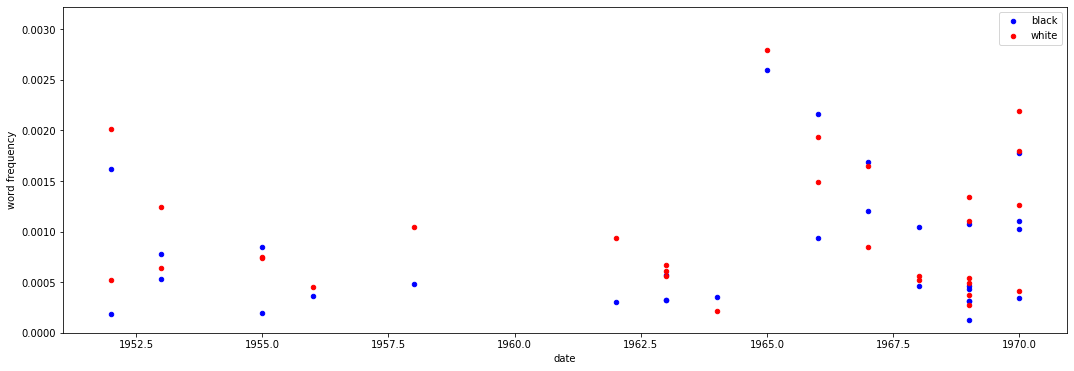

In [113]:
import matplotlib.pyplot as plt

ax = df.plot.scatter(x = 'PUBL_DATE', y = 'black', color = 'b', label='black', figsize = (18,6))
ax = df.plot.scatter(x = 'PUBL_DATE', y = 'white', color = 'r', label = 'white', figsize = (18,6), ax = ax) # note the extra ax = ax argument
ax.set_ylim((0,df['black'].max()+df['black'].std())) # setting the y axis 
ax.set_ylabel('word frequency')
ax.set_xlabel('date')
# write your file to disk as a .png (Portable Network Graphics) file
plt.savefig('/Users/e/Downloads/my_scatterplot.png')

## Saving data frames to disk
Pandas makes it easy to write data frames to disk.

Let's say we wanted to save a version of our document-term matrix with our merged metadata:

In [114]:
df.set_index(['FILENAME','PUBL_DATE','LIBRARIES','TITLE'], inplace = True)

In [115]:
df.head()

,,,,a,aaron,abandoned,able,about,above,abruptly,absence,absolutely,absurd,...,your,youre,yours,yourself,youth,youve,yul,zelenko,zulfiqar,colors_combined
FILENAME,PUBL_DATE,LIBRARIES,TITLE,,,,,,,,,,,,,,,,,,,,,
00020055.txt,1952,1577,Invisible Man,0.025098,NaN,0.000011,0.000068,0.002253,0.000649,0.000028,0.000006,0.000045,0.000040,...,0.002270,0.000768,0.000062,0.000203,0.000079,0.000231,NaN,NaN,NaN,0.001304
00020063.txt,1952,2499,The old man and the sea,0.014889,NaN,NaN,0.000113,0.001088,0.000300,NaN,NaN,0.000038,NaN,...,0.001125,0.000338,0.000038,0.000188,NaN,0.000038,NaN,NaN,NaN,0.001425
00020084.txt,1953,953,Go tell it on the mountain,0.016666,NaN,0.000037,0.000311,0.001628,0.000485,0.000112,NaN,NaN,NaN,...,0.001740,0.000050,0.000062,0.000099,0.000025,NaN,NaN,NaN,NaN,0.000497
00020085.txt,1953,2080,The adventures of Augie March,0.022344,0.000008,0.000020,0.000192,0.003251,0.000132,0.000004,0.000004,0.000084,0.000008,...,0.001499,0.000814,0.000044,0.000253,0.000012,0.000164,NaN,NaN,NaN,0.001106
00023482.txt,1955,1226,Island in the sun,0.025263,NaN,0.000018,0.000411,0.002953,0.000175,0.000022,0.000048,0.000031,0.000039,...,0.001925,0.000490,0.000118,0.000302,0.000018,0.000429,NaN,NaN,NaN,0.000543


We can write this to a CSV (comma separated values) file with this command:

In [116]:
filepath = '/Users/e/Downloads/df_test.csv'
df.to_csv(filepath)

And then we can check to see that it opens correctly in Excel or Numbers like so:

In [117]:
!open '/Users/e/Downloads/df_test.csv'

And then we could put this same data into Tableau.

(It takes Tableau 1-2 minutes to load up this data.)

We can also subset the data using the usual method:

In [119]:
df[colors].stack()

FILENAME      PUBL_DATE  LIBRARIES  TITLE                                    
00020055.txt  1952       1577       Invisible Man                      red       0.000570
                                                                       orange    0.000051
                                                                       yellow    0.000102
                                                                       green     0.000237
                                                                       blue      0.000344
00020063.txt  1952       2499       The old man and the sea            red       0.000150
                                                                       yellow    0.000488
                                                                       green     0.000263
                                                                       blue      0.000525
00020084.txt  1953       953        Go tell it on the mountain         red       0.000174
                      

Tableau works best with what are called `stacked` dataframes, which can be created quite easily using the `stack()` method:

In [120]:
df[colors].stack().to_csv(filepath, header = True)

# Biplots

These functions will enable us to make a biplot. In our case, a biplot is a scatterplot representation where the x-axis and the y-axis are the scaled frequencies of specific words, and the points in the two-dimensional space (hence the "bi" in biplot) are the positions of each text *on those dimensions*.

This allows us to see how texts behave with respect to specific words without looking through huge data tables, and we can more easily see how certain texts are grouped together, and how others exceed or fall beneath the groups that they're a part of:

In [201]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

In [202]:
def biplot(df, x_col, y_col, label_col=None):
    # to ensure we only plot points with valid x & y coordinates:
    df = df[df[x_col].notna() & df[y_col].notna()]
    # using our new df:
    max_x=df[x_col].max()
    max_y=df[y_col].max()
    ax = df.plot(x=x_col,y=y_col,kind='scatter',xlim=(0,max_x),ylim=(0,max_y),figsize=(10,10))
    if label_col:
        label_point(df[x_col], df[y_col], df[label_col], ax)

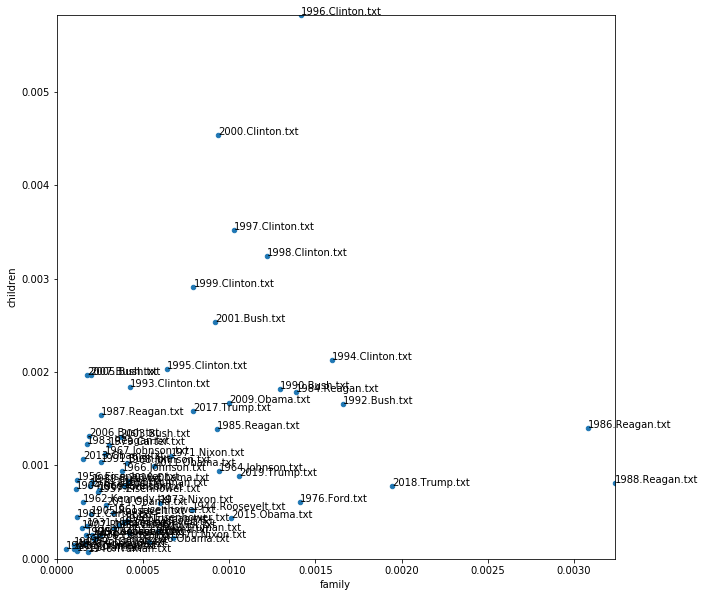

In [203]:
biplot(df, 'family','children', 'filepath')

Pandas uses a plotting library called `matplotlib` to make these graphs. This is the conventional way to import it:

In [200]:
from matplotlib import pyplot as plt

This is a modified version of the above `biplot` function that allows us to mark groups from our dataframe for visualization.

In [204]:
def biplot_groups(df, x_col, y_col, group_col=None, label_col=None, figsize=(10,10)):
    # to ensure we only plot points with valid x & y coordinates:
    df = df[df[x_col].notna() & df[y_col].notna()]
    
    max_x = df[x_col].max()
    max_y = df[y_col].max()
    
    groups = df.groupby(group_col)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group[x_col], group[y_col], marker='o', linestyle='', ms=8, label=name)
        label_point(group[x_col], group[y_col], group[label_col], ax)
    ax.legend()
    plt.xlabel(x_col, fontsize=16)
    plt.ylabel(y_col, fontsize=16)

    plt.show()
    

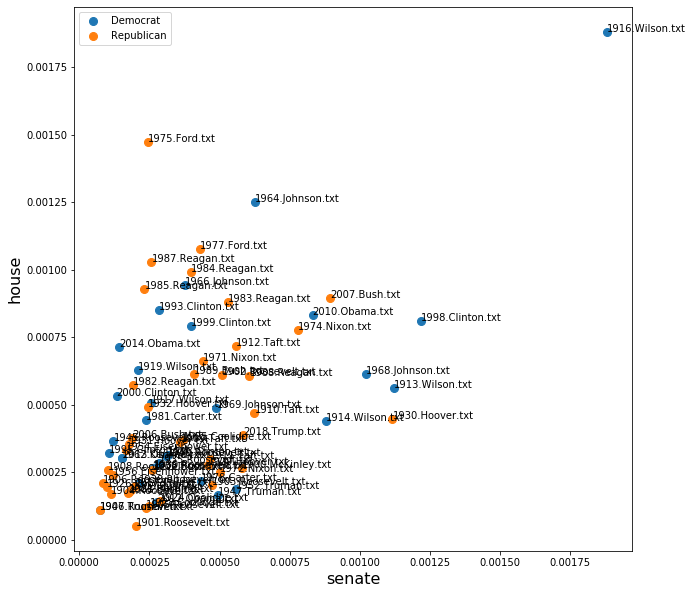

In [205]:
biplot_groups(df, 'senate', 'house', 'party', 'filepath')

Wilson's 1916 SOTU is the *extraordinary* outlier for mentions of the House and the Senate among all States of the Union.

Let's try out some other conventional ideological distinctions:

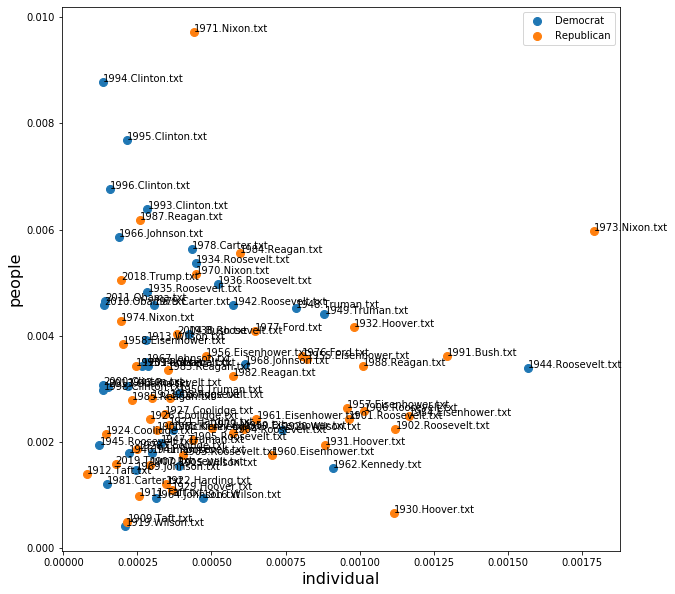

In [206]:
biplot_groups(df, 'individual', 'people', 'party', 'filepath')

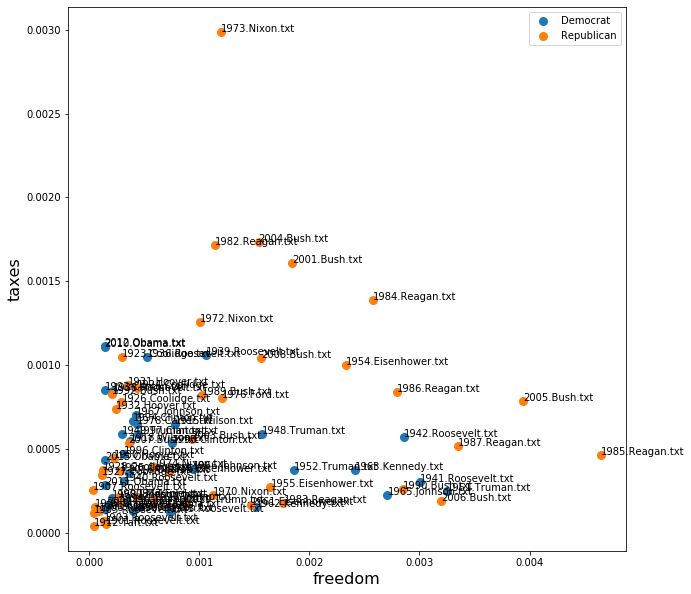

In [207]:
biplot_groups(df, 'freedom', 'taxes', 'party', 'filepath')

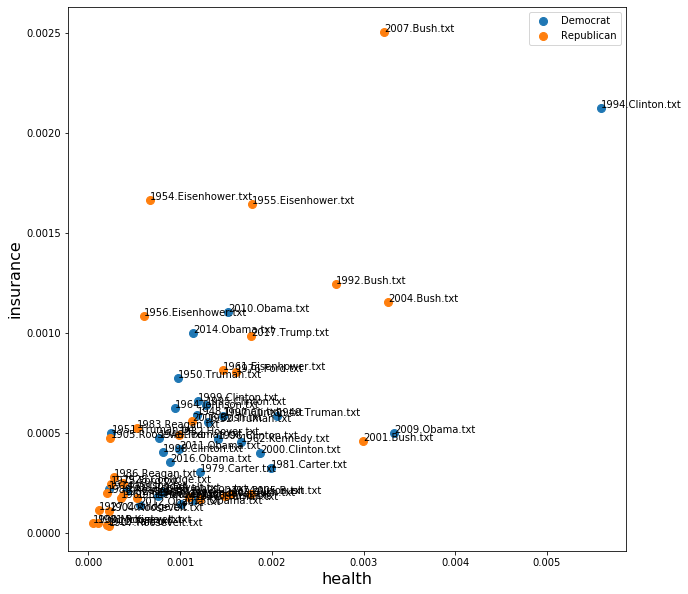

In [227]:
biplot_groups(df, 'health', 'insurance', 'party', 'filepath')

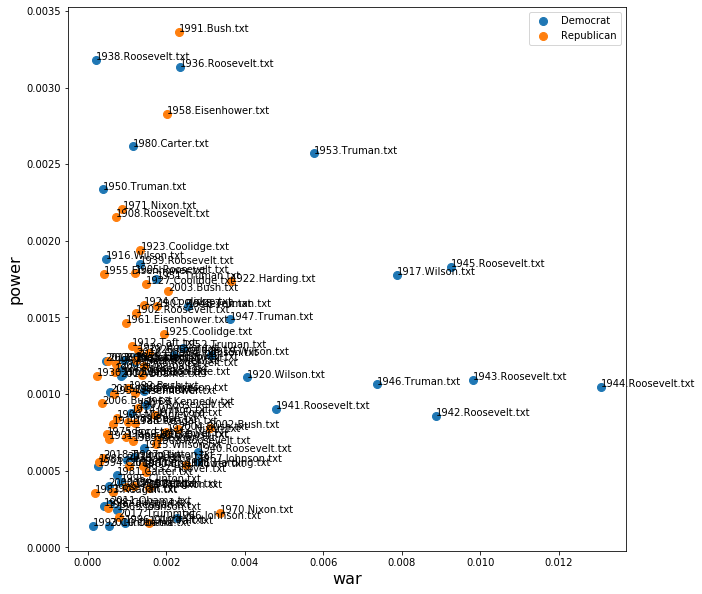

In [209]:
biplot_groups(df, 'war', 'power', 'party', 'filepath')

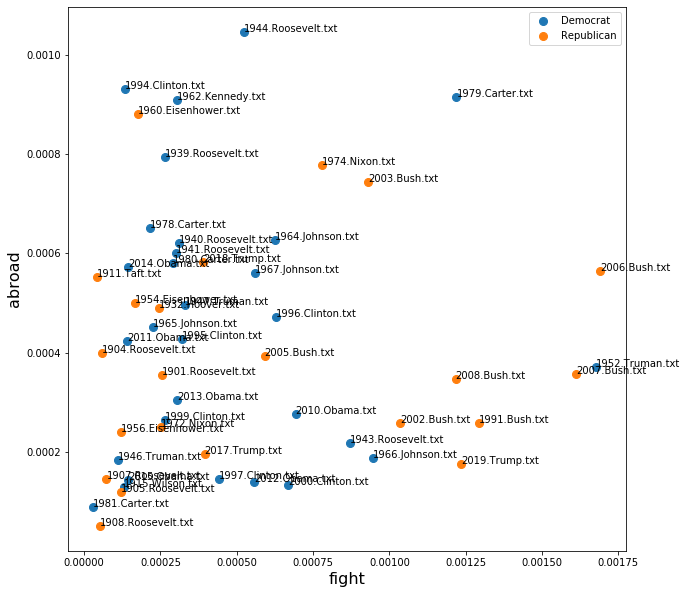

In [210]:
biplot_groups(df, 'fight', 'abroad', 'party', 'filepath')

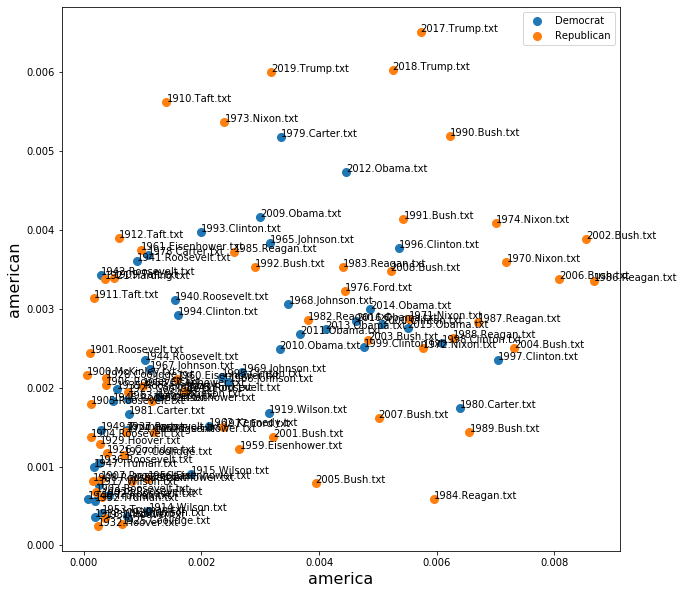

In [217]:
biplot_groups(df, 'america', 'american', 'party', 'filepath')

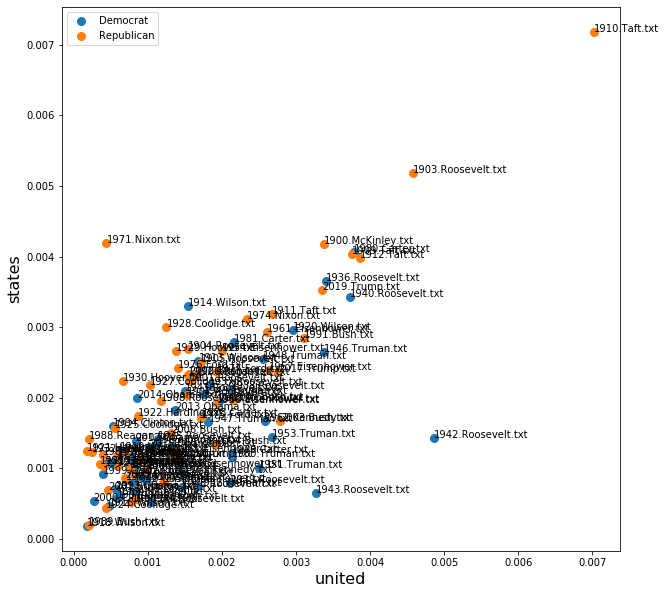

In [218]:
biplot_groups(df, 'united', 'states', 'party', 'filepath')

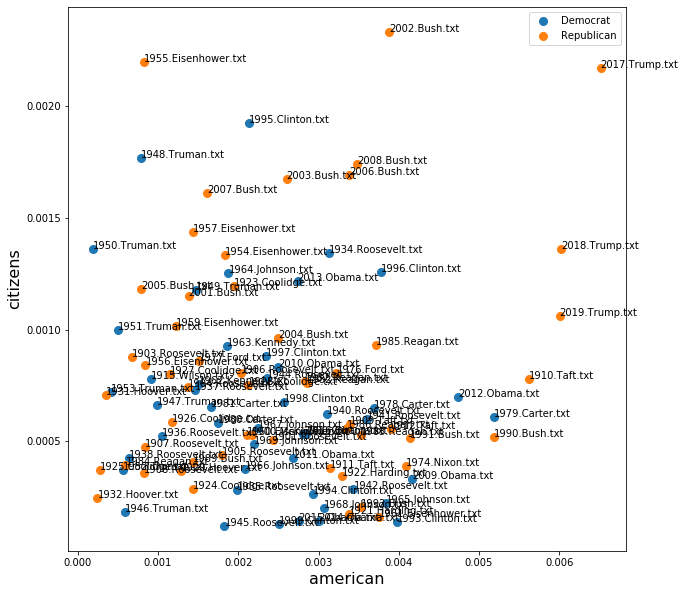

In [222]:
biplot_groups(df, 'american', 'citizens', 'party', 'filepath')

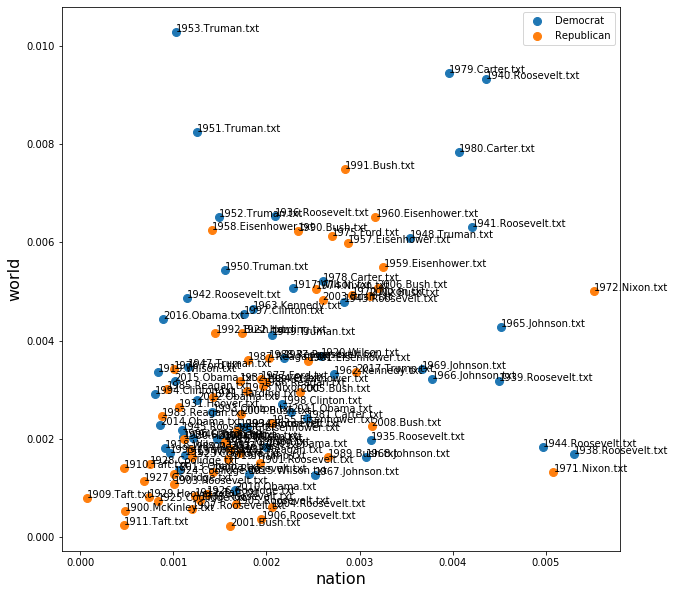

In [223]:
biplot_groups(df, 'nation', 'world', 'party', 'filepath')

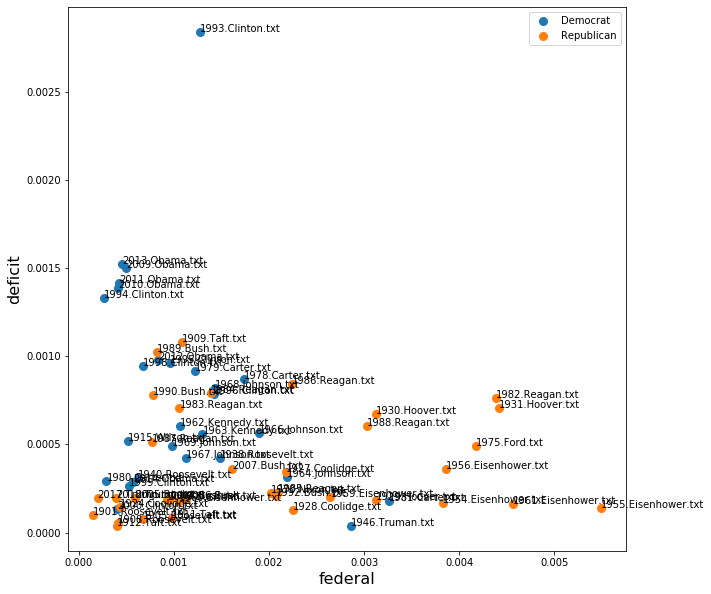

In [241]:
biplot_groups(df, 'federal', 'deficit', 'party', 'filepath')

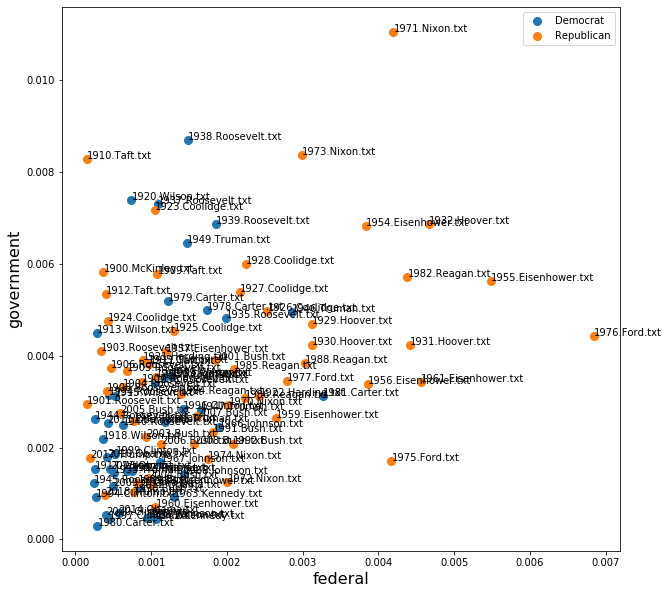

In [243]:
biplot_groups(df, 'federal', 'government', 'party', 'filepath')

We can also have it plot some random relationships:

In [224]:
import random
random_words = list(words.copy())

In [228]:
random.shuffle(random_words)

In [229]:
random_words[:5]

['spending', 'industry', 'things', 'never', 'total']

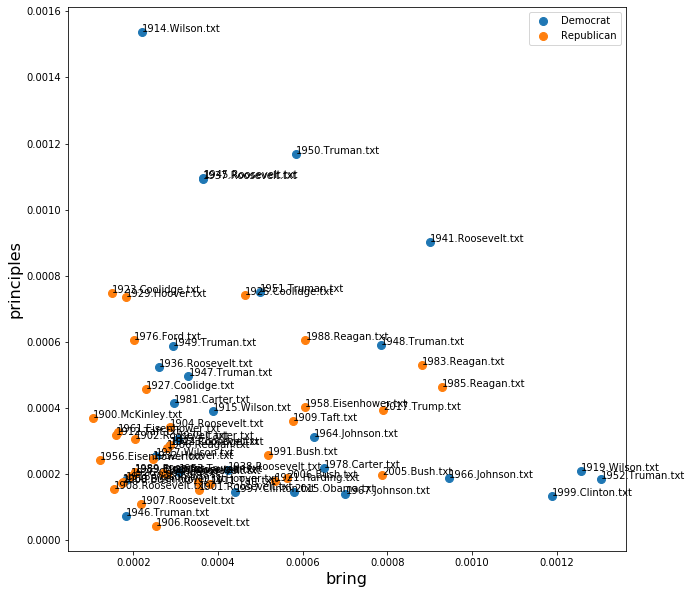

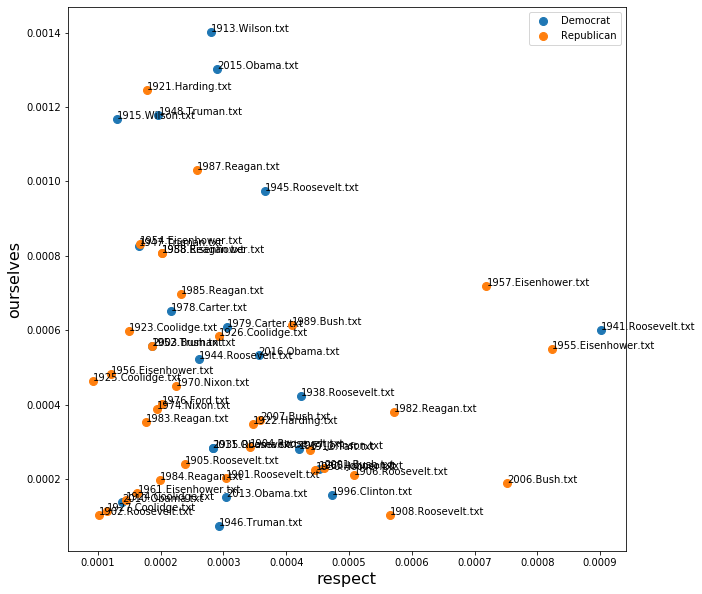

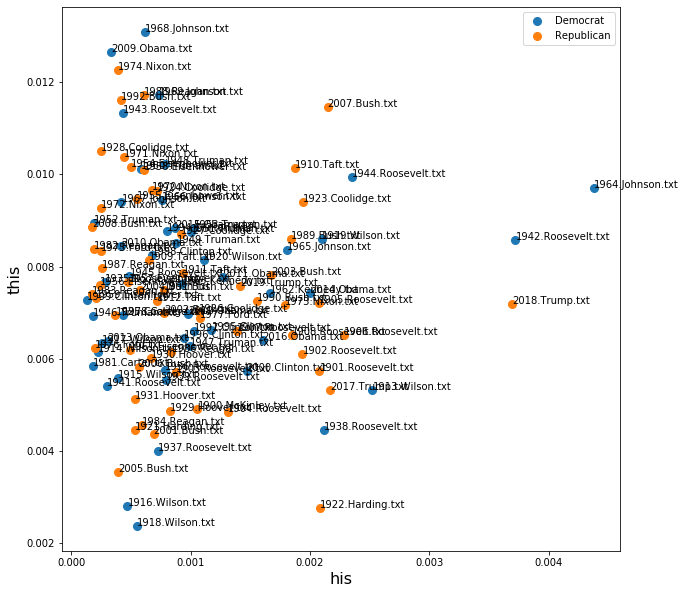

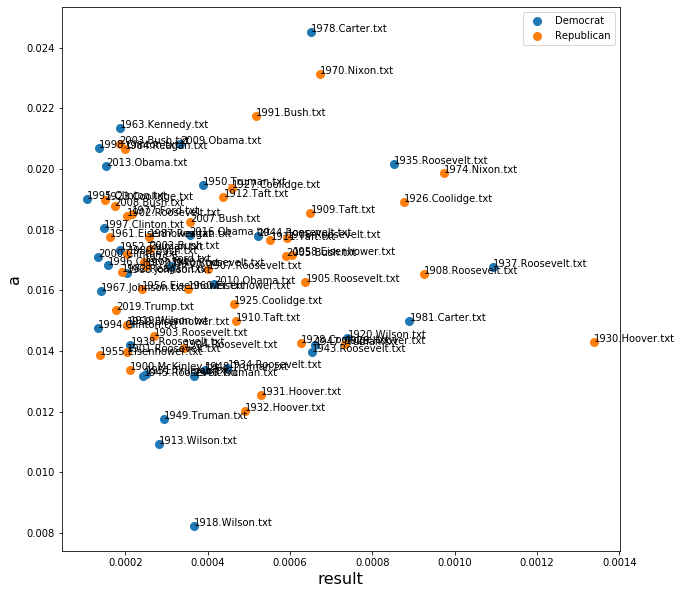

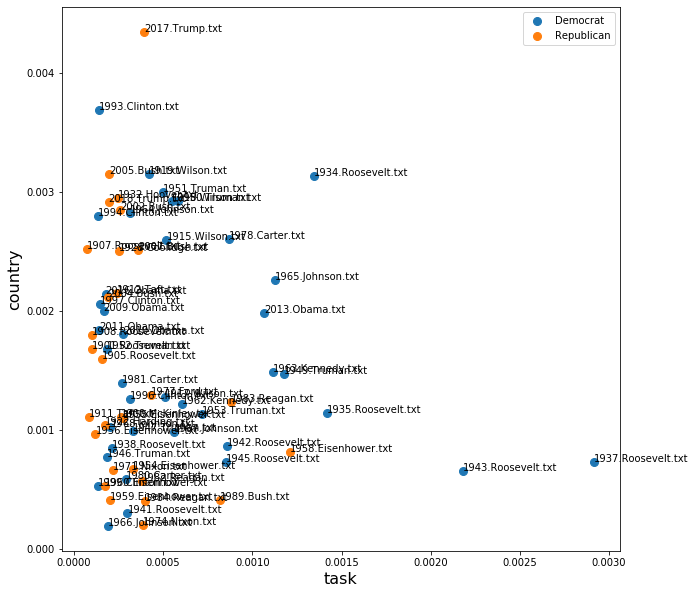

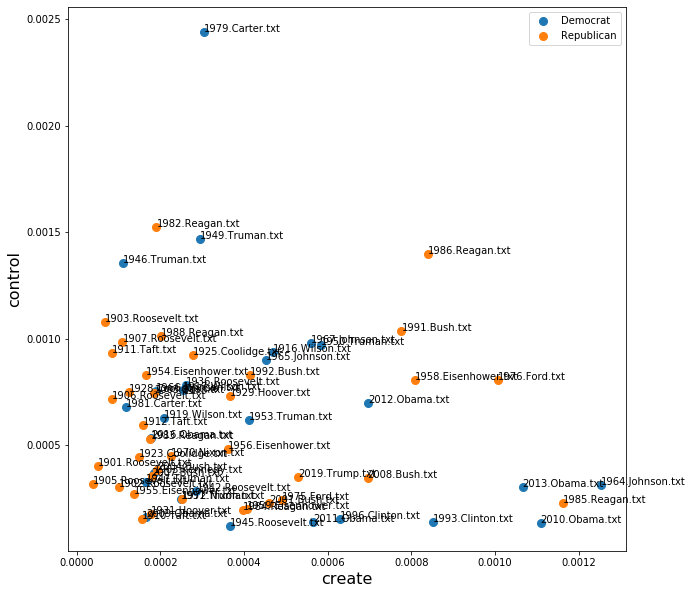

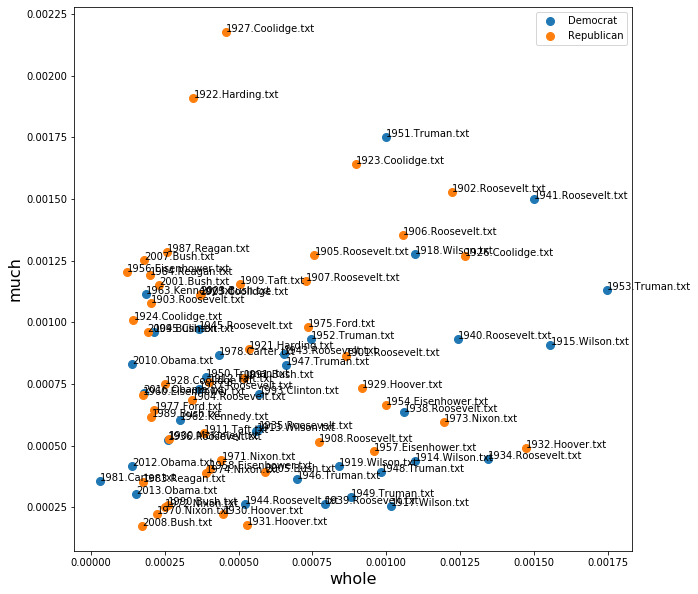

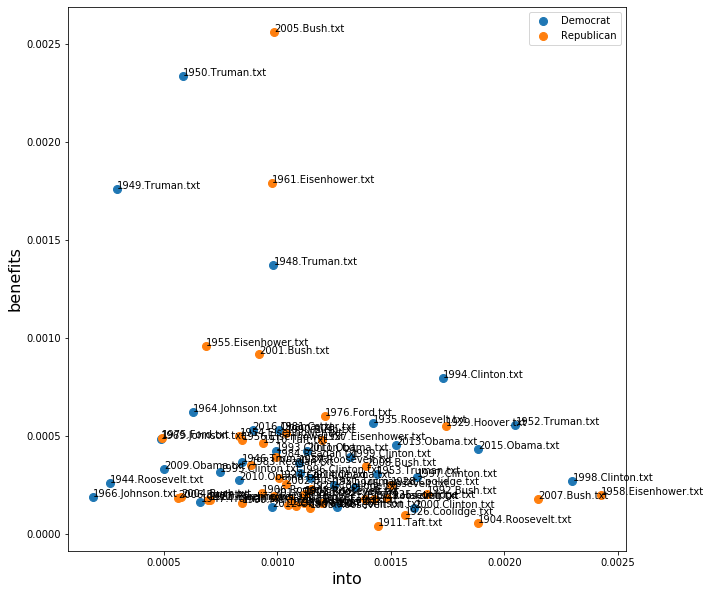

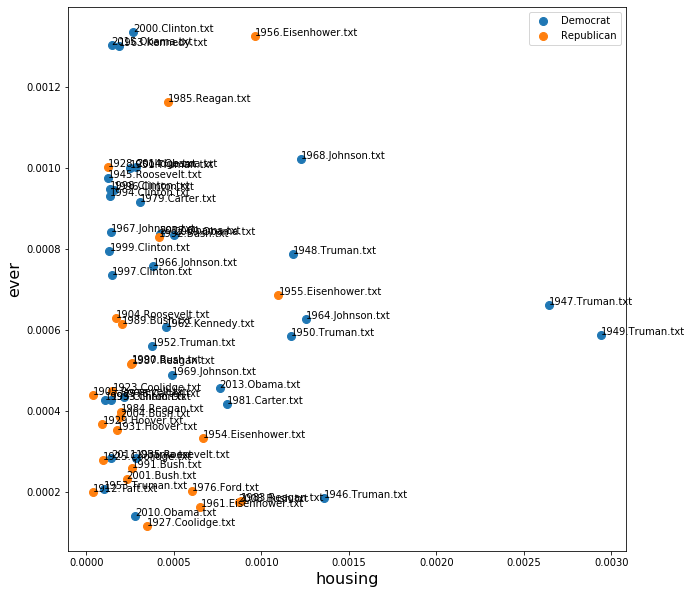

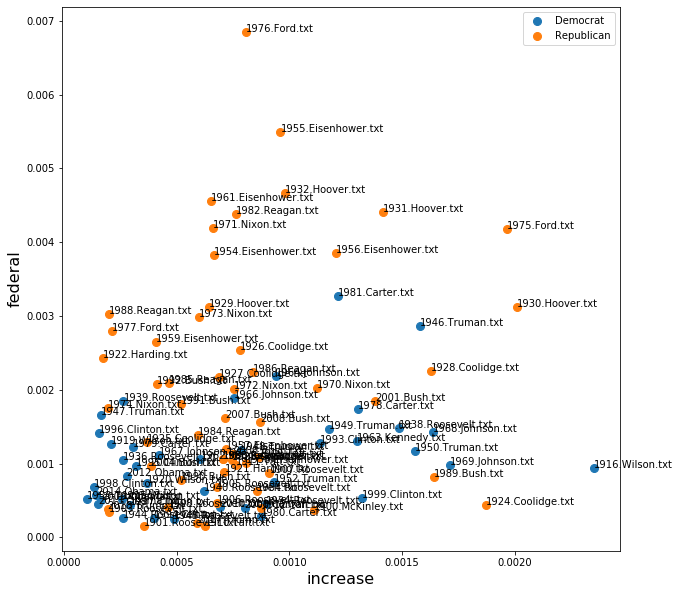

In [230]:
x = 10
while x > 0:
    random.shuffle(random_words)
    biplot_groups(df, random_words[0], random_words[1], 'party', 'filepath')
    x -= 1

# Finding words that move together over time
It's easy to visualize multiple words simultaneously. We just pass a list of variables to the `y` argument:

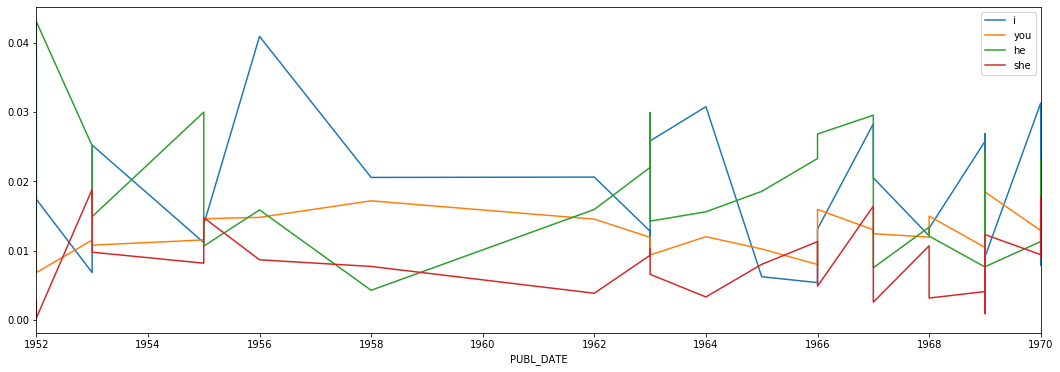

In [221]:
df.plot(x = 'PUBL_DATE', y = ['i','you','he','she'], figsize = (18,6))

There's no clear pattern about the relationship between these words. But surely there are words that move together in this dataset. We can find them using correlation, as discussed in Heuser and Le-Khac's pamphlet, and in Underwood's *Distant Reading*.

In [61]:
df.set_index(['FILENAME','PUBL_DATE', 'LIBRARIES'], inplace=True)

We're going to set our variables as indices so that we don't correlate those:

In [62]:
df.head()

,,,a,able,about,above,across,act,actually,afraid,after,afternoon,...,york,you,youd,youll,young,your,youre,yourself,youve,yul
FILENAME,PUBL_DATE,LIBRARIES,,,,,,,,,,,,,,,,,,,,,
00020055.txt,1952,1577,0.025098,0.000068,0.002253,0.000649,0.000666,0.000215,0.000147,0.000243,0.000683,0.000085,...,0.000119,0.013766,0.000175,0.000497,0.000638,0.002270,0.000768,0.000203,0.000231,NaN
00020063.txt,1952,2499,0.014889,0.000113,0.001088,0.000300,0.001013,NaN,0.000038,0.000188,0.001238,0.000150,...,0.000038,0.006826,NaN,0.000038,0.000113,0.001125,0.000338,0.000188,0.000038,NaN
00020084.txt,1953,953,0.016666,0.000311,0.001628,0.000485,0.000186,0.000037,0.000012,0.000186,0.000969,0.000099,...,0.000112,0.011509,0.000075,0.000037,0.000584,0.001740,0.000050,0.000099,NaN,NaN
00020085.txt,1953,2080,0.022344,0.000192,0.003251,0.000132,0.000136,0.000100,0.000128,0.000104,0.001150,0.000204,...,0.000084,0.010783,0.000168,0.000281,0.000349,0.001499,0.000814,0.000253,0.000164,NaN
00023482.txt,1955,1226,0.025263,0.000411,0.002953,0.000175,0.000525,0.000066,0.000114,0.000184,0.000989,0.000319,...,0.000109,0.011542,0.000319,0.000267,0.000836,0.001925,0.000490,0.000302,0.000429,NaN


This method, `.corr()`, correlates every column with every other column:

In [65]:
df_cor = df.corr()

The result looks like this:

In [67]:
df_cor.head()

,a,able,about,above,across,act,actually,afraid,after,afternoon,...,york,you,youd,youll,young,your,youre,yourself,youve,yul
a,1.000000,-0.115929,0.152107,0.001776,-0.298591,0.177691,0.243702,-0.079840,-0.145685,0.470194,...,0.394861,-0.134884,0.373683,0.535002,0.065974,0.142661,0.502231,0.132020,0.462317,NaN
able,-0.115929,1.000000,0.133955,-0.225089,-0.250849,0.246311,0.060415,0.688184,0.105366,0.001975,...,0.118108,0.064635,0.057634,-0.300560,0.193316,-0.095991,-0.394629,-0.019854,0.013789,NaN
about,0.152107,0.133955,1.000000,-0.411627,-0.084643,0.142593,0.206005,0.143998,0.371300,0.220886,...,0.138778,0.467208,0.177639,0.394475,-0.223887,0.096720,0.235479,0.084520,0.103428,NaN
above,0.001776,-0.225089,-0.411627,1.000000,0.405078,0.174737,-0.260679,-0.086733,-0.456771,-0.303111,...,-0.324308,0.012814,-0.171700,-0.039386,0.102968,0.059541,0.080805,-0.132627,0.222634,NaN
across,-0.298591,-0.250849,-0.084643,0.405078,1.000000,0.077514,-0.070115,-0.116260,0.041840,-0.147148,...,-0.458341,0.022809,0.017210,-0.042621,-0.160298,-0.129147,0.030244,-0.134108,0.070132,NaN


Let's see what our most strongly positive and strongly negative correlations with these words are:

In [69]:
df_cor['i'].sort_values(ascending = False)

marjorie       1.000000
essie          1.000000
noel           1.000000
i              1.000000
louise         0.956818
me             0.879258
myself         0.855240
my             0.717124
simply         0.600248
we             0.536649
do             0.536133
seems          0.526361
please         0.501409
why            0.494141
feel           0.479373
mine           0.471087
act            0.468948
us             0.454458
stayed         0.454313
drink          0.452948
laughing       0.449469
our            0.447657
seem           0.436979
walking        0.436343
have           0.434042
fight          0.422761
sorry          0.422425
certainly      0.421916
dr             0.420630
perhaps        0.419835
                 ...   
his           -0.508652
il            -0.567639
skin          -0.615061
jacob         -0.687709
granny        -0.730556
ed            -0.747494
grange        -0.756104
digger        -0.769967
foxy          -0.950155
simon         -1.000000
beulah        -1

And what do these look like on the graph?

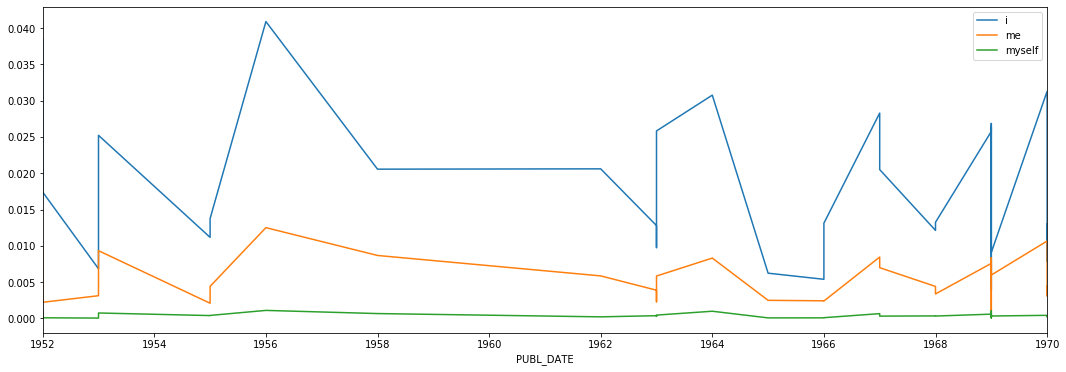

In [76]:
df.reset_index().plot(x = 'PUBL_DATE', y = ['i', 'me','myself'], figsize = (18,6))

What about negative correlations? (When A goes up, B goes down.)

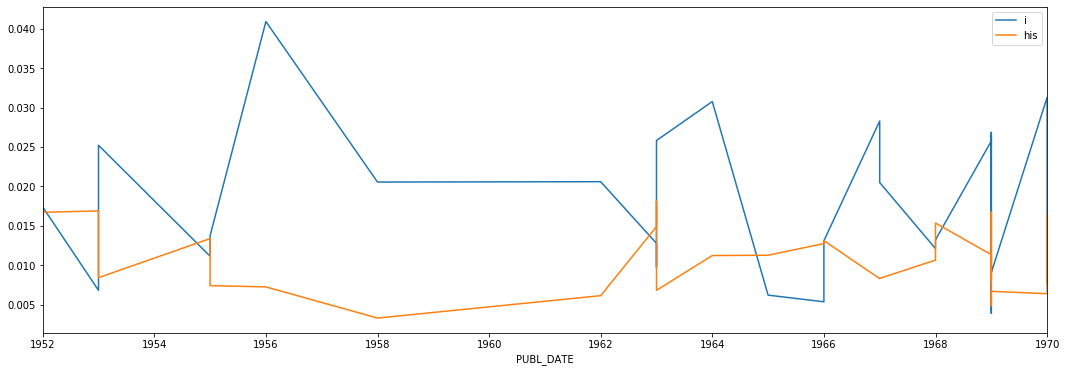

In [79]:
df.reset_index().plot(x = 'PUBL_DATE', y = ['i', 'his'], figsize = (18,6))

We generally ignore values equal to `1` since of course words are perfectly correlated with themselves. In cases where words are also perfectly correlated, it's very likely that they only appear in one or a few books together.

## Which words trend up or down?
We can figure out a first approximation to this by calculating the slope of the line for each word.

In [82]:
from statistics import mean
import numpy as np

def best_fit(xs,ys):
    '''Calcluate line of best fit, returning slope and intercept.'''
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b

In [83]:
df.reset_index(inplace=True)

Now we can calculate trends for the whole dataframe:

In [89]:
output = []
for word in df.columns[3:]:
    d = {}
    m,b = best_fit(xs = df['PUBL_DATE'], ys = df[word])
    d['word'] = word
    d['slope'] = m
    d['intercept'] = b
    output.append(d)

In [92]:
pd.DataFrame(output).dropna().sort_values('slope')

,intercept,slope,word
361,0.808540,-0.000403,he
401,0.720291,-0.000358,i
29,0.470910,-0.000224,and
582,0.341043,-0.000171,not
839,0.320425,-0.000157,that
417,0.302788,-0.000148,it
342,0.280570,-0.000139,had
924,0.192524,-0.000091,was
506,0.174706,-0.000088,man
592,0.160542,-0.000081,old


This is a small dataset, so we see that 'her' trends weakly up, while 'he'trends weakly down:

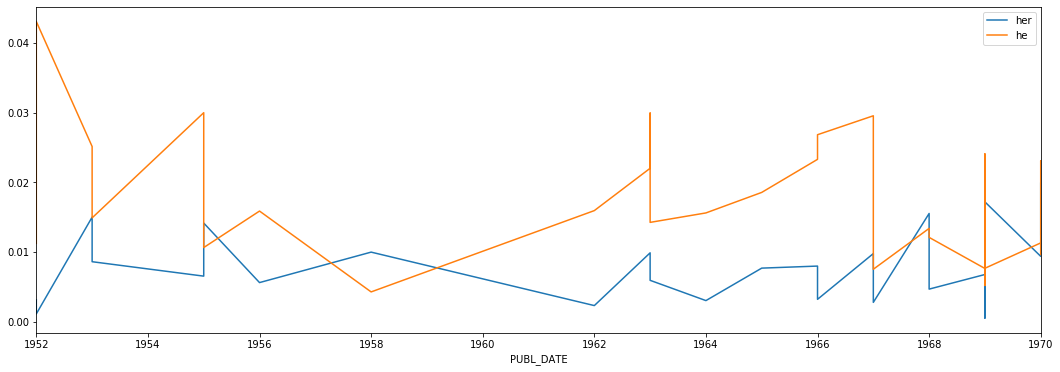

In [97]:
df.plot(x = 'PUBL_DATE', y = ['her','he'], figsize = (18,6))

`her` starts low and goes higher; `he` starts high and winds up lowering over the corpus.

## N-gram frequencies over time
We have discussed the limits of counting by single words when some words in combination create meanings distinct from either of their components individually.

# Topic Modeling
As we discussed in the Blei article, topic modeling allows us to access a "topic," a collection of word probabilities measured at the level of their distribution in documents.

We're going to begin with the State of the Union corpus for its small scale:

In [ ]:
sotus = '/Users/e/code/literarytextmining/corpora/sotu_1900-2019/texts'

The package `gensim` will allow us to create the topic model:

In [106]:
import gensim
# maybe not:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# `nltk` bigrams

We're also going to use a few old friends from `nltk` to preprocess our texts.

Here are the steps:
1. Make a giant list containing every word from every text in our corpus (ok because this is a small corpus; we would sample if it were bigger).
2. Check that list for frequent bigrams and trigrams.
3. Make a dictionary to preprocess our texts to incorporate the bi- and trigrams.

In [138]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')

In [139]:
texts = absolute_paths(sotus)

In [140]:
texts[:3]

['/Users/e/code/literarytextmining/corpora/sotu_1900-2019/texts/1929.Hoover.txt',
 '/Users/e/code/literarytextmining/corpora/sotu_1900-2019/texts/1907.Roosevelt.txt',
 '/Users/e/code/literarytextmining/corpora/sotu_1900-2019/texts/1951.Truman.txt']

Let's get all of the words for all of our texts in a big list.

`gensim` expects a list of sentences

In [160]:
# initializing the list outside of the loop
# why? because we want *all* of the words in one list:
corp_sents = [] 
for text in texts: # all texts
    text = open(text).read()
    sents = nltk.sent_tokenize(text)
    
    for sent in sents: # all sentences in each text
        toks = tokenize(sent)
        sent_toks = []
        for tok in toks: # all tokens in each sentence
            if tok not in stopwords: # drop stopwords
                sent_toks.append(tok)
        # append results to list
        corp_sents.append(sent_toks)
            

In [162]:
len(corp_sents)

37073

In [186]:
# train a model to recognize bigrams and trigrams for this corpus
bigram = gensim.models.Phrases(corp_sents, min_count = 5, threshold = 50)
# the "threshold" argument sets the number of sentences an ngram

In [186]:
# pass the trained model to Phraser
# this saves the model and improves performance
bigram_model = gensim.models.phrases.Phraser(bigram)

Now, `bigram` model we made will automatically join together tokens that are part of a known pair with an `_` character:

In [187]:
bigram_model[corp_sents[168]]

['public_buildings',
 'provisions',
 'various',
 'acts',
 'congress',
 'authorized',
 'public_buildings',
 'land',
 'upon',
 'construct',
 'district_columbia',
 'country',
 'large']

Next we need to apply the model to each sentence in turn:

In [188]:
sents = []
for sent in corp_sents:
    sents.append(bigram_model[sent])

Now, we can create the data that we're going to pass to the topic modeling algorithm:

In [195]:
gensim_dict = gensim.corpora.Dictionary(sents)

In [196]:
corpus = []
for sent in sents:
    out = gensim_dict.doc2bow(sent)
    corpus.append(out)

This is going to look a little weird:

In [204]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 2),
 (14, 1),
 (15, 2)]

In [208]:
sorted(sents[0])

['congress',
 'consideration',
 'constitution',
 'give',
 'information',
 'judge',
 'measures',
 'necessary_expedient',
 'president',
 'recommend',
 'representatives',
 'requires',
 'senate_house',
 'shall',
 'shall',
 'state_union',
 'time',
 'time']

`gensim` creates a number corresponding to each word in the corpus, and counts its frequency in each sentence. It does this because it is faster to process numbers than strings for a variety of reasons. Our `gensim_dict` variable contains the relationships:

In [210]:
gensim_dict[0], gensim_dict[1], gensim_dict[2]

('congress', 'consideration', 'constitution')

# Building the model
We're here! Let's make our topic model.

We're going to use what's called `lda`, or [Latent Dircihelet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) as our method.

Like I mentioned last time, we have to make a bunch of decisions up front:

In [211]:
# this takes about 5 minutes on my computer
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=gensim_dict,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Now we can view our results:

In [212]:
lda_model.print_topics()

[(0,
  '0.253*"united_states" + 0.129*"years" + 0.065*"past" + 0.051*"conference" + 0.049*"economic" + 0.037*"character" + 0.035*"held" + 0.033*"great_britain" + 0.029*"abroad" + 0.024*"brought"'),
 (1,
  '0.275*"american" + 0.112*"good" + 0.102*"service" + 0.045*"amount" + 0.042*"importance" + 0.040*"per_cent" + 0.034*"corporations" + 0.033*"tax" + 0.033*"settlement" + 0.023*"central"'),
 (2,
  '0.209*"must" + 0.066*"general" + 0.063*"purpose" + 0.054*"know" + 0.044*"certain" + 0.043*"come" + 0.040*"life" + 0.038*"within" + 0.038*"keep" + 0.029*"senate"'),
 (3,
  '0.153*"nation" + 0.139*"two" + 0.106*"peace" + 0.059*"high" + 0.049*"taken" + 0.048*"education" + 0.043*"become" + 0.043*"effort" + 0.033*"continued" + 0.030*"strength"'),
 (4,
  '0.238*"national" + 0.187*"need" + 0.099*"day" + 0.090*"therefore" + 0.087*"result" + 0.061*"never" + 0.024*"estimated" + 0.000*"law" + 0.000*"last" + 0.000*"system"'),
 (5,
  '0.464*"upon" + 0.083*"future" + 0.040*"sound" + 0.038*"condition" + 0.03

# Running our topic model with MALLET

In [218]:
mallet_path = '/Users/e/code/Mallet/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             num_topics=20,
                                             id2word=gensim_dict)

CalledProcessError: Command '/Users/e/code/Mallet/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/9m/h2k_qg994mv0s9vcm6dx9g900000gn/T/e82909_corpus.txt --output /var/folders/9m/h2k_qg994mv0s9vcm6dx9g900000gn/T/e82909_corpus.mallet' returned non-zero exit status 1.